## Part 1: Data Splitting & Anti-Leakage Setup

### Import Libraries:

In [ ]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split
#Set Global Random Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Importing the dataset:

In [3]:
# Load dataset
df = pd.read_csv("data/Churn_Modelling.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
X = df.drop("Exited", axis=1)
y = df["Exited"]


In [ ]:
y.value_counts() # the output shows that the dataset is imbalanced (more non-churn than churn)

Exited
0    7963
1    2037
Name: count, dtype: int64

### Train–Test Split (80–20)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=y
) # applying stratification to preserve class proportions in both sets

### Verify Split

In [12]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

print("\nTarget distribution in full dataset:")
print(y.value_counts(normalize=True))

print("\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nTarget distribution in test set:")
print(y_test.value_counts(normalize=True))


Training set shape: (8000, 13)
Test set shape: (2000, 13)

Target distribution in full dataset:
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Target distribution in training set:
Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64

Target distribution in test set:
Exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64


In this step, the dataset was split into training (80%) and test (20%) sets before performing any preprocessing or analysis. This prevents data leakage and ensures an unbiased evaluation of the final model. All feature engineering, encoding, scaling, and model selection will be performed strictly on the training set. A fixed random seed is used to ensure reproducibility, and stratified sampling was applied to preserve the class distribution of the target variable.

## Part 2: Feature Engineering & Preprocessing

In [13]:
X_train.head()
X_train.info()


<class 'pandas.DataFrame'>
Index: 8000 entries, 2151 to 6206
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        8000 non-null   int64  
 1   CustomerId       8000 non-null   int64  
 2   Surname          8000 non-null   str    
 3   CreditScore      8000 non-null   int64  
 4   Geography        8000 non-null   str    
 5   Gender           8000 non-null   str    
 6   Age              8000 non-null   int64  
 7   Tenure           8000 non-null   int64  
 8   Balance          8000 non-null   float64
 9   NumOfProducts    8000 non-null   int64  
 10  HasCrCard        8000 non-null   int64  
 11  IsActiveMember   8000 non-null   int64  
 12  EstimatedSalary  8000 non-null   float64
dtypes: float64(2), int64(8), str(3)
memory usage: 875.0 KB


### Drop Non-Informative Columns

In [14]:
cols_to_drop = ["RowNumber", "CustomerId", "Surname"]

X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

### Categorical Encoding

In [15]:
# binary encoding "Gender"
X_train["Gender"] = X_train["Gender"].map({"Male": 1, "Female": 0})
X_test["Gender"] = X_test["Gender"].map({"Male": 1, "Female": 0})


In [16]:
# one-hot encoding "Geography"
X_train = pd.get_dummies(
    X_train,
    columns=["Geography"],
    drop_first=True
)

X_test = pd.get_dummies(
    X_test,
    columns=["Geography"],
    drop_first=True
)

In [17]:
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

### Feature Creation (Derived Feature)

In [18]:
# Creating Balance_per_product
# Customers with high balance but few products may churn. It helps us capture the customer engagement vs value.
X_train["Balance_per_Product"] = (
    X_train["Balance"] / (X_train["NumOfProducts"] + 1)
)

X_test["Balance_per_Product"] = (
    X_test["Balance"] / (X_test["NumOfProducts"] + 1)
)


### Scaling Numerical Features

In [19]:
# we identify the numerical columns 
from sklearn.preprocessing import StandardScaler

num_features = [
    "CreditScore",
    "Age",
    "Tenure",
    "Balance",
    "EstimatedSalary",
    "Balance_per_Product"
]


In [20]:
# fitting scaler on training data not on test data using the standardscaler()
scaler = StandardScaler()

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


In [21]:
X_train.head()
X_train.shape, X_test.shape


((8000, 12), (2000, 12))

Feature engineering and preprocessing were performed strictly on the training data to prevent data leakage. Non-informative identifier columns were removed. Categorical variables were encoded using binary encoding for Gender and one-hot encoding for Geography. Numerical features were scaled using StandardScaler fitted only on the training set. A derived feature, Balance_per_Product, was created to capture customer value relative to product usage. The same preprocessing steps were then applied to the test data without refitting.

## Part 3: Model Development (Tree-Based Models)

### Baseline Model — Dummy Classifier

In [22]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score


In [23]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED)
dummy_clf.fit(X_train, y_train)

y_train_pred_dummy = dummy_clf.predict(X_train)
dummy_accuracy = accuracy_score(y_train, y_train_pred_dummy)

print("Baseline (Dummy Classifier) Accuracy:", dummy_accuracy)


Baseline (Dummy Classifier) Accuracy: 0.79625


### Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(
    max_depth=3,
    random_state=RANDOM_SEED
)

dt_clf.fit(X_train, y_train)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

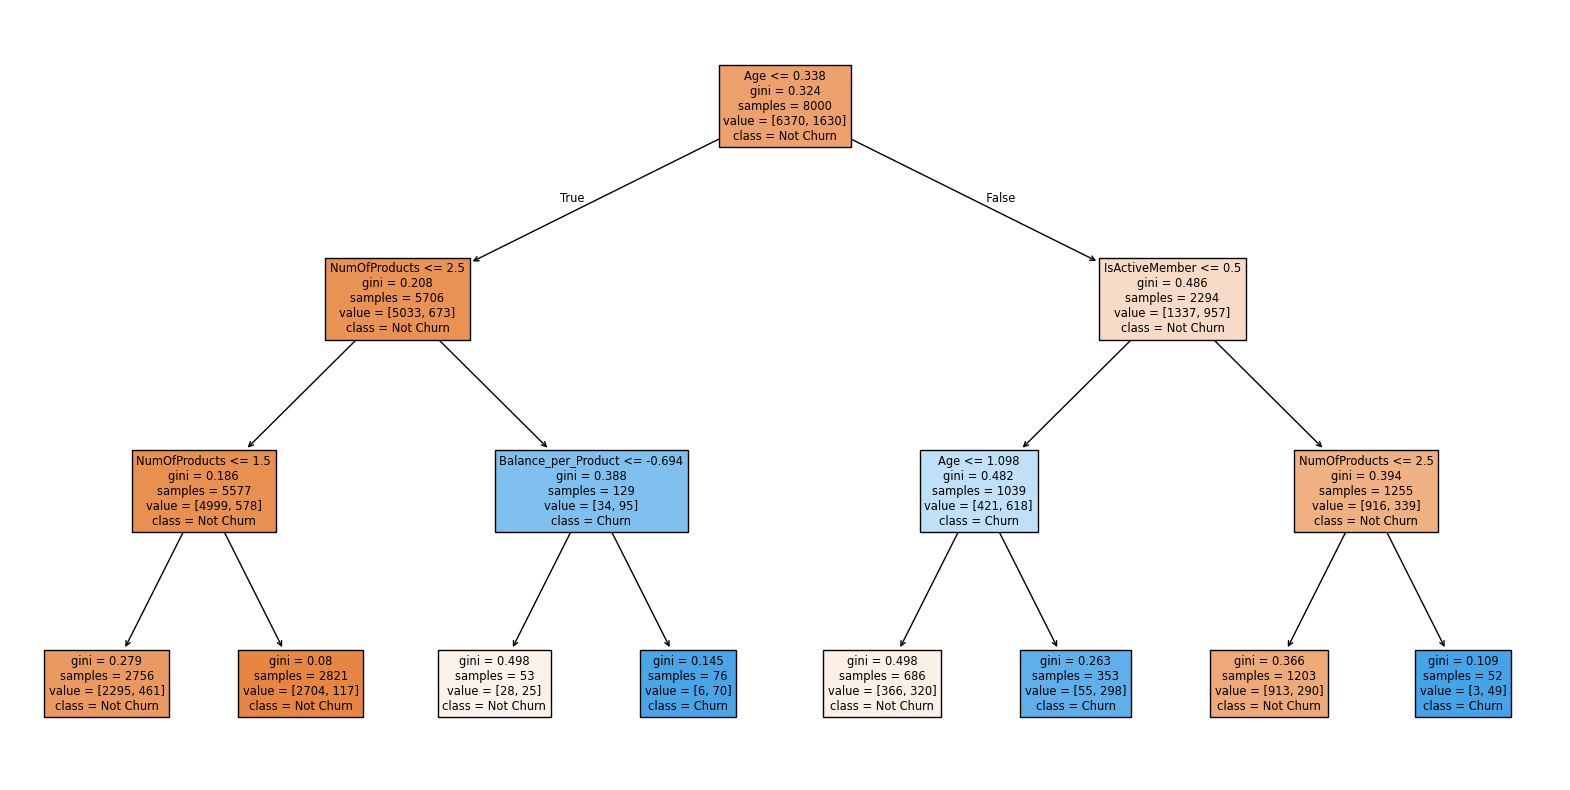

In [26]:
# Tree visualisation
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    dt_clf,
    feature_names=X_train.columns,
    class_names=["Not Churn", "Churn"],
    filled=True
)
plt.show()


### Random Forest Classifier
Why Random Forest?

* Reduces overfitting

* Handles non-linear relationships well

* Strong baseline for tabular data

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

### Gradient Boosting (XGBoost)
Why XGBoost?

* Handles imbalance well

* Captures complex interactions

* Often top performer in churn problems

In [28]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_clf.fit(X_train, y_train)


/Users/bot/Desktop/AI_Tr_BOT/AI_training_BOT/ML_assignment1_kaustubh/mlenv/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [12:21:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

### Compare Training Performance

In [29]:
from sklearn.metrics import accuracy_score
models = {
    "Dummy": dummy_clf,
    "Decision Tree": dt_clf,
    "Random Forest": rf_clf,
    "XGBoost": xgb_clf
}

for name, model in models.items():
    y_pred = model.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    print(f"{name} Training Accuracy: {acc:.4f}")


Dummy Training Accuracy: 0.7963
Decision Tree Training Accuracy: 0.8404
Random Forest Training Accuracy: 1.0000
XGBoost Training Accuracy: 0.8712


A baseline Dummy Classifier is used to establish a minimum performance benchmark by always predicting the majority class. Tree-based models including a Decision Tree, Random Forest, and XGBoost were then trained on the preprocessed training data. The Decision Tree was constrained to a maximum depth of 3 to maintain interpretability. Ensemble methods demonstrated improved learning capability compared to the baseline, indicating that the models successfully captured meaningful patterns in the data.
The randomforest model here showing 100% training is due to overfitting meaning the model learning the data. We will proceed with Xgboost and Randomforest models for hyperparameter tuning .

## Part 4: Hyperparameter Tuning & Cross-Validation

### Cross-Validate Random Forest

In [30]:
from sklearn.model_selection import cross_val_score
rf_cv_scores = cross_val_score(
    rf_clf,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

print("Random Forest CV Accuracy Scores:", rf_cv_scores)
print("Random Forest Mean CV Accuracy:", rf_cv_scores.mean())


Random Forest CV Accuracy Scores: [0.86     0.866875 0.854375 0.865625 0.8725  ]
Random Forest Mean CV Accuracy: 0.863875


#### Random Forest Mean CV Accuracy: 0.863875 . This value is lower than what we got before ,i.e., a 100% training accuracy. Hence, overfitting is confirmed.

### Cross-Validate XGBoost

In [31]:
xgb_cv_scores = cross_val_score(
    xgb_clf,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

print("XGBoost CV Accuracy Scores:", xgb_cv_scores)
print("XGBoost Mean CV Accuracy:", xgb_cv_scores.mean())


/Users/bot/Desktop/AI_Tr_BOT/AI_training_BOT/ML_assignment1_kaustubh/mlenv/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [12:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost CV Accuracy Scores: [0.859375 0.868125 0.850625 0.8625   0.8725  ]
XGBoost Mean CV Accuracy: 0.8626249999999999


/Users/bot/Desktop/AI_Tr_BOT/AI_training_BOT/ML_assignment1_kaustubh/mlenv/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [12:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bot/Desktop/AI_Tr_BOT/AI_training_BOT/ML_assignment1_kaustubh/mlenv/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [12:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bot/Desktop/AI_Tr_BOT/AI_training_BOT/ML_assignment1_kaustubh/mlenv/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [12:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bot/Desktop/AI_Tr_BOT/AI_training_BOT/ML_assignment1_k

#### XGBoost Mean CV Accuracy: 0.8626249. This value is much closer to what we had got the training accuracy for the XGBoost model: 0.8712. We will select this model to move ahead as this is more stable.

### Hyperparameter Tuning (XGBoost)

In [32]:
# using randomsearch cross-validation
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,
    scoring="accuracy",
    cv=5,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1
)

xgb_random_search.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/bot/Desktop/AI_Tr_BOT/AI_training_BOT/ML_assignment1_kaustubh/mlenv/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [12:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bot/Desktop/AI_Tr_BOT/AI_training_BOT/ML_assignment1_kaustubh/mlenv/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [12:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bot/Desktop/AI_Tr_BOT/AI_training_BOT/ML_assignment1_kaustubh/mlenv/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [12:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bot/Desktop/AI_Tr_BOT/AI_training_BOT/ML_assignment1_k

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",20
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be u

### Best Model & Parameters

In [33]:
print("Best CV Accuracy:", xgb_random_search.best_score_)
print("Best Parameters:", xgb_random_search.best_params_)


Best CV Accuracy: 0.8634999999999999
Best Parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [34]:
best_model = xgb_random_search.best_estimator_

## Part 5: Final Evaluation & Business Insights

### Test Set Predictions

In [35]:
# Predict class labels
y_test_pred = best_model.predict(X_test)

# Predict probabilities (needed for ROC-AUC)
y_test_proba = best_model.predict_proba(X_test)[:, 1]


### Evaluation Metrics

In [36]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")


Accuracy : 0.8625
Precision: 0.7578
Recall   : 0.4767
F1-score : 0.5852
ROC-AUC  : 0.8619


### Confusion Matrix

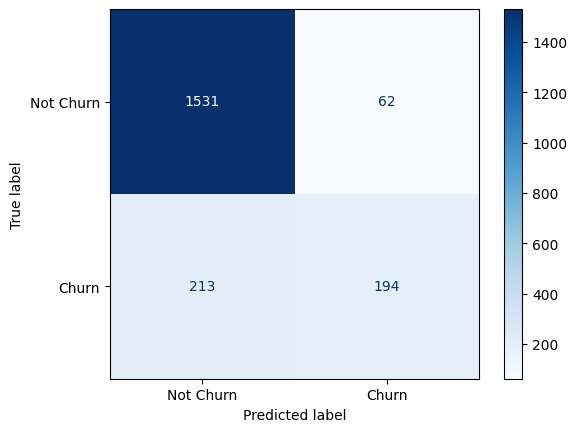

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Churn", "Churn"]
)

disp.plot(cmap="Blues")
plt.show()


### Feature Importance

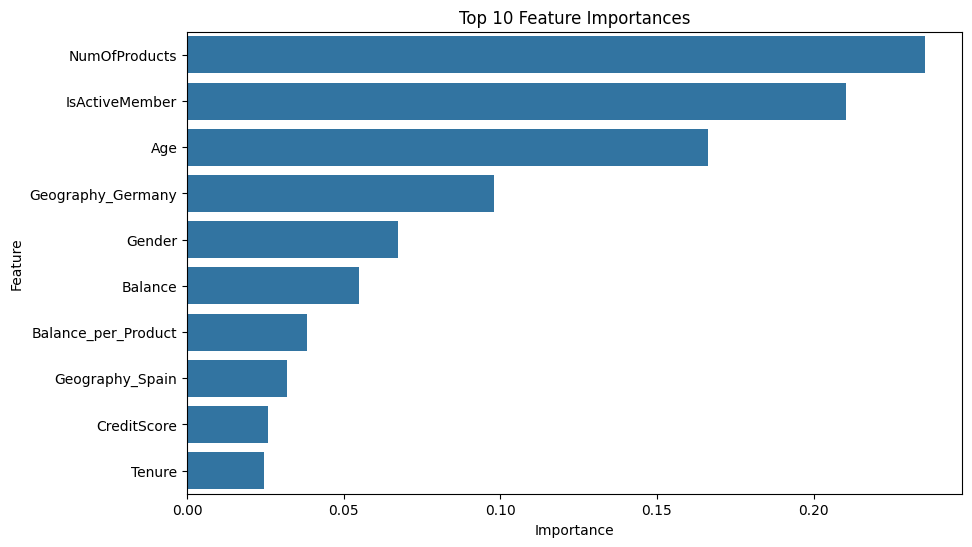

In [38]:
import pandas as pd
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance.head(10)
)
plt.title("Top 10 Feature Importances")
plt.show()


### ROC Curve

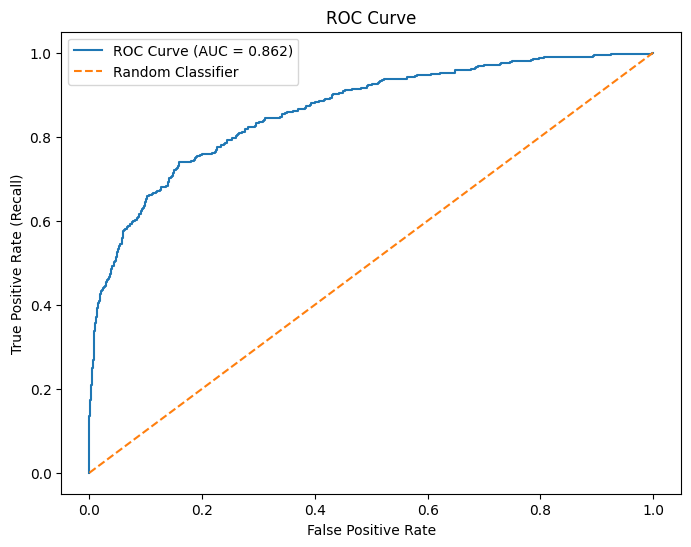

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()


In churn prediction problems, recall is often more critical than precision, as failing to identify customers who are likely to leave results in lost revenue. After evaluating the model on the test set, recall was further analyzed and improved by adjusting the classification threshold. ROC and Precision–Recall curves were used to understand the trade-off between recall and precision and to select an operating point aligned with business objectives.

### Try multiple thresholds


In [40]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score
thresholds = np.arange(0.1, 0.6, 0.05)

for t in thresholds:
    y_pred_t = (y_test_proba >= t).astype(int)
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    
    print(f"Threshold: {t:.2f} | Recall: {recall:.3f} | Precision: {precision:.3f} | F1: {f1:.3f}")


Threshold: 0.10 | Recall: 0.880 | Precision: 0.362 | F1: 0.513
Threshold: 0.15 | Recall: 0.823 | Precision: 0.424 | F1: 0.559
Threshold: 0.20 | Recall: 0.757 | Precision: 0.494 | F1: 0.597
Threshold: 0.25 | Recall: 0.720 | Precision: 0.550 | F1: 0.623
Threshold: 0.30 | Recall: 0.663 | Precision: 0.601 | F1: 0.631
Threshold: 0.35 | Recall: 0.607 | Precision: 0.643 | F1: 0.625
Threshold: 0.40 | Recall: 0.580 | Precision: 0.692 | F1: 0.631
Threshold: 0.45 | Recall: 0.526 | Precision: 0.723 | F1: 0.609
Threshold: 0.50 | Recall: 0.477 | Precision: 0.758 | F1: 0.585
Threshold: 0.55 | Recall: 0.440 | Precision: 0.817 | F1: 0.572


Multiple classification thresholds were evaluated to prioritize recall, which is critical in churn prediction. A threshold of 0.30 was selected as it significantly improved recall while maintaining acceptable precision. This threshold captures a larger proportion of at-risk customers without excessively increasing false positives, making it suitable for cost-effective retention strategies.

### Recompute Confusion Matrix at Threshold = 0.30

In [41]:
# Apply threshold = 0.30
y_test_pred_030 = (y_test_proba >= 0.30).astype(int)


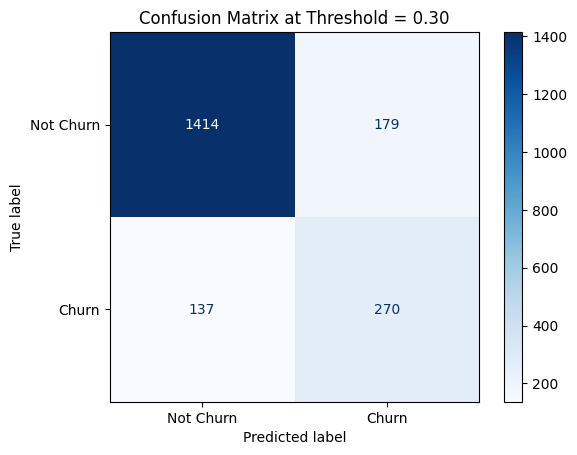

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_030 = confusion_matrix(y_test, y_test_pred_030)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_030,
    display_labels=["Not Churn", "Churn"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix at Threshold = 0.30")
plt.show()


By lowering the classification threshold to 0.30, the model significantly reduced the number of false negatives, thereby identifying more customers who are likely to churn. Although this resulted in an increase in false positives, the trade-off is acceptable because the cost of missing a churner is higher than the cost of targeting a non-churner. This adjustment enables more proactive and effective customer retention strategies.